In [1]:
from gworacle import query, mass, snr
from astropy.utils.data import download_file
import json, numpy
from pycbc import init_logging

data = query.get_gracedb_superevents(cache=True)

# Downselect event gracedb
far_threshold = 1e-6 # This will exclude a lot of real BBH signals, but only the quiet ones

prod = [k for k in data if k['category'] == 'Production' and ('DQOK' in k['labels'] or 'ADVOK' in k['labels'])]
print("Production events", len(prod))

sig = [k for k in prod if k['far'] <= far_threshold]
print("Pass FAR threshold", len(sig))

ret = []
for s in sig:
    root_url = s['links']['files']
    fdir = download_file(root_url, cache=True)
    flist = json.load(open(fdir, 'r'))
    if 'Retraction' in ' '.join(flist):
        ret.append(s)

# Remove the retracted ones
for s in ret:
    sig.remove(s)
print("After removing retractions", len(sig))

# Organize by id
events = {k['superevent_id']: {'data':k} for k in sig}

/home/ahnitz/projects/pycbc/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


Production events 4021
Pass FAR threshold 454
After removing retractions 417


In [2]:
from astropy.utils.data import download_file
import json

bstar_bsn = {}

for s in events:
    dat = events[s]['data']
    root_url = dat['links']['files']
    fdir = download_file(root_url, cache=True)
    flist = json.load(open(fdir, 'r'))

    name = dat['superevent_id']
    try:
        file = download_file(flist['bayestar.html'], cache=True, show_progress=True)                   
    except:
        continue

    with open(file, 'r') as f:
        s = f.read()
        x = s.find('LOGBSN')
        r = s[x:].split('>')[2].split('<')[0]
        bsn = float(r)
        bstar_bsn[name] = bsn
        print(name, bsn)

S250331o 187.51026668047126
S250328ae 206.5341106566025
S250327u 11.902203951226511
S250326y 16.029337209579673
S250321l 8.959857956406218
S250319bu 12.32516170080976
S250318bl 10.160361826854652
S250315ab 4.871674892289961
S250313aj 9.00413796843472
S250313j 7.103536330679717
S250309co 11.796397604440555
S250304df 9.401021809313546
S250304cb 12.832135840570098
S250303bf 10.63549237089761
S250228p 7.189877267712961
S250227e 21.278391830358352
S250226dl 23.958922154538058
S250214bv 7.817156049343938
S250211be 10.466009973647548
S250211aa 27.159071218776468
S250208ad 14.49135942927371
S250207da 10.357385892167308
S250207bg 795.4911551056836
S250206dm 18.789048402496498
S250205ee 12.926948776077314
S250205bk 36.35952703534261
S250204ax 29.14264184704508
S250204ar 9.479264420438906
S250202cu 9.92282939308759
S250201i 12.093084586744164
S250129p 8.802650360732677
S250123l 16.048589560009784
S250120ah 6.771108289895312
S250120x 10.159693855101793
S250119cv 124.81916795368338
S250119ag 51.191

In [3]:
import numpy
cat = numpy.genfromtxt("./4ogc.txt", dtype=str)
times = [float(k[2]) for k in cat]
names = [k[1] for k in cat]

gtimes = numpy.array([float(s['t_end']) for s in sig])

hsnr = [float(k[-3]) for k in cat]
lsnr = [float(k[-2]) for k in cat]
vsnr = [float(k[-1]) for k in cat]

nsnrs = []
for i in range(len(hsnr)):
    nsnr = sum([x**2.0 for x in [hsnr[i], lsnr[i], vsnr[i]] if x != -1]) ** 0.5
    nsnrs.append(nsnr)


import numpy
cat = numpy.genfromtxt("./pe.txt", dtype=str, delimiter=',')
names2 = [k[0] for k in cat]
psnrs = [float(k[28]) for k in cat]

idx = [names2.index(n) for n in names]

gsnrs = {}
gsnrs2 = {}
for i, t in enumerate(times):
    k = numpy.where(abs(gtimes - t) < 2)[0]
    if len(k) == 0:
        continue

    k = k[0]

    name = sig[k]['superevent_id']
    gsnrs[name] = nsnrs[i]
    gsnrs2[name] = psnrs[idx[i]]

LinregressResult(slope=1.1190443019768193, intercept=3.5842339957691234, rvalue=0.9918490182831188, pvalue=1.0637534423875614e-25, stderr=0.027666422048497848, intercept_stderr=0.31889650785287355)
77.35633313205082
<function f2 at 0x7fa8b6044220>


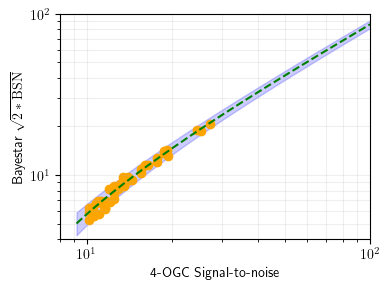

In [4]:
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
from scipy.stats import linregress
from scipy.interpolate import interp1d
from scipy import stats

s2 = []
v = []
for name in gsnrs:
    try:
        s02 = gsnrs2[name]
        v0 = bstar_bsn[name]
        s2.append(s02)
        v.append(v0)
    except:
        pass
v = numpy.array(v)
s2 = numpy.array(s2)

bs = (v*2)**0.5

sf = linregress(bs[s2>12], s2[s2>12])
def f2(x):
    return sf.slope * x + sf.intercept

print(sf)

# Calculate confidence intervals
x = numpy.arange(2, 150)
y_pred = f2(x)
#n = len(x)
#t = stats.t.ppf(0.85, n - 2) # t-value for 95% confidence interval
#print(t)
#std_err_slope = sf.stderr
#std_err_intercept = sf.stderr * np.sqrt(np.mean(x**2))
#y_upper = y_pred + t * np.sqrt(std_err_slope**2 * (x - np.mean(x))**2 + std_err_intercept**2)
#y_lower = y_pred - t * np.sqrt(std_err_slope**2 * (x - np.mean(x))**2 + std_err_intercept**2)
y_upper =  (sf.slope + 2 * sf.stderr) * x + (sf.intercept + 2 * sf.intercept_stderr)
y_lower =  (sf.slope - 2 * sf.stderr) * x + (sf.intercept - 2 * sf.intercept_stderr)


yl = interp1d(y_upper, x)
yu = interp1d(y_lower, x)

x = numpy.arange(5, 100, .01)
print(f2((2173*2)**0.5))

plt.figure(figsize=[4, 3])
plt.scatter(s2, bs, color='orange')
plt.plot(f2(x), x, color='green', linestyle='--')

plt.fill_between(f2(x), yu(f2(x)), yl(f2(x)), alpha=0.2, zorder=-1, color='blue')

plt.xlabel('4-OGC Signal-to-noise')
plt.ylabel('Bayestar $\sqrt{2 * \\textrm{BSN}}$')

print(f2)

plt.grid(which='both', alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.xlim(8, 100)
plt.ylim(4, 100)

bs_snrs = {}
for k in bstar_bsn:
    bs_snrs[k] = f2((bstar_bsn[k]*2)**0.5)
plt.tight_layout()
plt.savefig('snrfit.pdf')

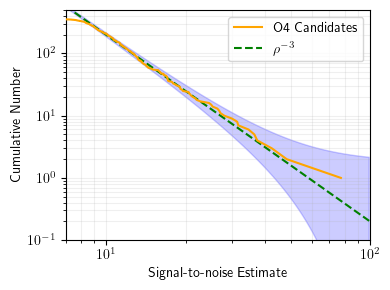

In [5]:
import numpy as np
from scipy.stats import chi2

def poisson_error(n_observed: int, confidence_level: float = 0.6827) -> tuple[float, float]:
    alpha = 1 - confidence_level

    # Lower bound on the rate (lambda)
    # Based on solving P(n >= n_observed | lambda_lower) = alpha / 2
    # This is equivalent to lambda_lower = 0.5 * chi2.ppf(alpha / 2, 2 * n_observed)
    df_lower = 2 * n_observed
    p_lower = alpha / 2
    lower_bound = chi2.ppf(p_lower, df_lower) / 2

    # Upper bound on the rate (lambda)
    # Based on solving P(n <= n_observed | lambda_upper) = alpha / 2
    # This is equivalent to lambda_upper = 0.5 * chi2.ppf(1 - alpha / 2, 2 * (n_observed + 1))
    df_upper = 2 * (n_observed + 1)
    p_upper = 1 - alpha / 2
    upper_bound = chi2.ppf(p_upper, df_upper) / 2

    return (lower_bound, upper_bound)

from matplotlib import pyplot as plt
plt.rc('text', usetex=True)
plt.figure(figsize=[4,3])

snrs = numpy.array(list(bs_snrs.values()))

snrs.sort()
c = numpy.arange(1, len(snrs)+1)[::-1]

s = numpy.arange(7, 100, 1)
r = s**(-3.0) * 198000

plt.plot(snrs, c, label='O4 Candidates', color='orange', zorder=1000)
plt.plot(s, r, label='$\\rho^{-3}$', linestyle='--', color='green')

l, h = poisson_error(r, 0.68)
#print(l, h)
plt.fill_between(s, l, h, alpha=0.2, color='blue')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Signal-to-noise Estimate')
plt.ylim(0.1, 500)
plt.xlim(7, 100)
plt.ylabel('Cumulative Number')
plt.legend()
plt.grid(which='both', zorder=-1, alpha=0.2)
plt.tight_layout()
plt.savefig('snrcum.pdf')
# Hmm, can work out merger rate improved measurements! Assuming frozen mass distribution from 4-ogc!

301 451
1126259462 1135136360
[1 2 3]
1167559936 1188529256
[ 4  5  6  7  8  9 10 11 12 13 14 15 16]
1238166018 1253977218
[17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60]
1256655618 1269363618
[61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84
 85 86 87 88 89 90 91 92 93 94]


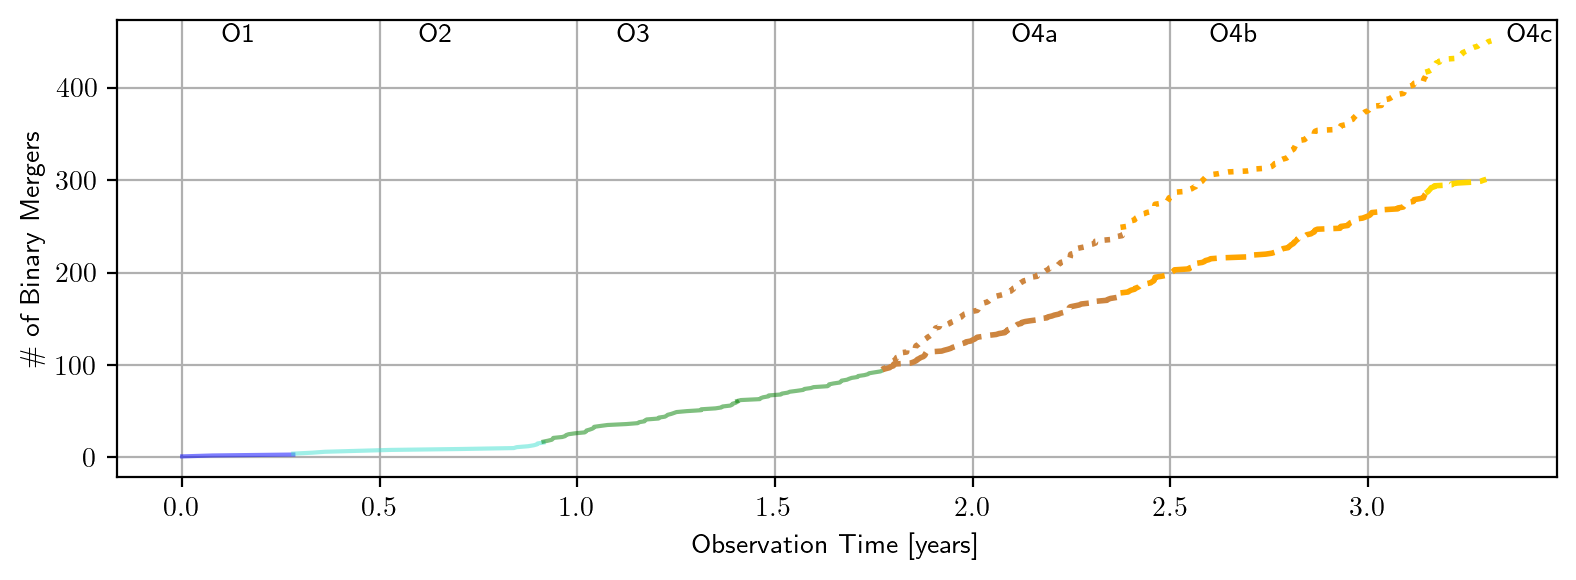

In [6]:
from matplotlib import pyplot as plt

plt.rc('text', usetex=True)
# o4a Ma 24, 2023 - Jan 16, 2024
# o4b April 10, 2024 - 
# o4c Jan 28, 2025

bounds = [(1126259462, 1135136360),
          (1167559936, 1188529256),
          (1238166018, 1253977218),
          (1256655618, 1269363618),
          (1338835218, 1388620818),
          (1396742418, 1422118818),
          (1422118818, 2422057618), 
         ]

times2 = numpy.array(times)

etimes = numpy.array([events[e]['data']['t_0'] for e in events])
efar  = numpy.array([events[e]['data']['far'] for e in events])

k = etimes > 1368835218
etimes = etimes[k]
efar = efar[k]


fars2 = numpy.concatenate([numpy.ones(len(times2))*1e-100, efar])
times2 = numpy.concatenate([times2, etimes])


l = times2.argsort()
times2 = times2[l]
fars2 = fars2[l]
tstart = times2.min()

times_year = (times2 - tstart) / 86400 / 365.25 
c = numpy.arange(1, len(l)+1, 1)

times3 = times2[fars2 < 1e-7]
times_year2 = (times3 - tstart) / 86400 / 365.25
c2 = numpy.arange(1, len(times3)+1, 1)

print((fars2 < 1e-7).sum(), len(times2))

plt.figure(figsize=[8,3], dpi=200)

obs = 0
colors = ['blue', 'turquoise', 'green', 'green', 'peru', 'orange', 'gold']

for i, (b, color) in enumerate(zip(bounds, colors)):

    if i > 3:
        k = (b[0] < times2) & (b[1] > times2)
        y, cd = times_year[k], c[k]
        plt.plot(y - y.min() + obs, cd, color=color, linestyle='dotted', linewidth=2)

        k = (b[0] < times3) & (b[1] > times3)
        y, cd = times_year2[k], c2[k]
        plt.plot(y - y.min() + obs, cd, color=color, linestyle='--', linewidth=2)
    else:
        print(b[0], b[1])
        k = (b[0] < times2) & (b[1] > times2)
        y, cd = times_year[k], c[k]

        print(c[k])
        plt.plot(y - y.min() + obs, cd, color=color, alpha=0.5)
        
    new_obs = y.max() - y.min()
    #print(obs)
    obs += new_obs
plt.text(0.1, 450, "O1")
plt.text(0.6, 450, "O2")
plt.text(1.1, 450, "O3")
plt.text(2.1, 450, "O4a")
plt.text(2.6, 450, "O4b")
plt.text(3.35, 450, "O4c")
plt.grid()
plt.xlabel("Observation Time [years]")
plt.ylabel("\# of Binary Mergers")
plt.tight_layout()
plt.savefig("observing.pdf")